# COMP4030 - Data Science and Machine Learning - Coursework 2

In [1]:
import matplotlib as mplt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# scaler = StandardScaler()
scaler = MinMaxScaler()

dfs = []
for g in ['circle', 'come', 'go', 'wave']:
      for i in range(1, 11):
            data = pd.read_csv(f'data/ash-{g}/{i}.csv')
            data = data.iloc[:, :-1] # we don't need absolute acceleration as it just a sum of the 3 axis
            data.columns = ['time', 'x', 'y', 'z']

            lower_percentile = data['time'].quantile(0.1)
            upper_percentile = data['time'].quantile(0.9)

            data = data[(data['time'] >= lower_percentile) & (data['time'] <= upper_percentile)] ## trim the edges of the data

            scaled_features = scaler.fit_transform(data)
            df = pd.DataFrame(scaled_features, columns=data.columns)
            df['i'] = i
            df['g'] = g
            dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

In [4]:
df.groupby(['g']).head()

,time,x,y,z,i,g
0,0.000000,0.601091,0.717052,0.291743,1,circle
1,0.001170,0.560832,0.788978,0.357836,1,circle
2,0.002339,0.500755,0.845857,0.443107,1,circle
3,0.003509,0.445015,0.861377,0.478107,1,circle
4,0.004678,0.378720,0.871647,0.576014,1,circle
7837,0.000000,0.720470,0.690776,0.671392,1,come
7838,0.001319,0.654664,0.607935,0.674608,1,come
7839,0.002639,0.683847,0.503056,0.782981,1,come
7840,0.003958,0.720272,0.417548,0.935184,1,come
7841,0.005277,0.691197,0.327298,0.983918,1,come


In [ ]:
# peaks_indices = []

# for dfr in df.groupby(['i', 'g']):
#     signal = dfr[1]['y'].values
#     peaks, _ = find_peaks(signal)
#     peaks_indices.append(peaks)

# reference_peak = 1
# reference_index = peaks_indices[0][reference_peak]

# aligned_dataframes = []
# i = 0

# for dfr in df.groupby(['i', 'g']):

#     shift_amount = reference_index - peaks_indices[i][reference_peak]

#     shifted_signal = np.roll(dfr[1]['y'].values, shift_amount)

#     aligned_df = pd.DataFrame(shifted_signal, columns=['y'])
#     aligned_dataframes.append(aligned_df)
#     i += 1

# aligned_df = pd.concat(aligned_dataframes, ignore_index=True)
# aligned_df

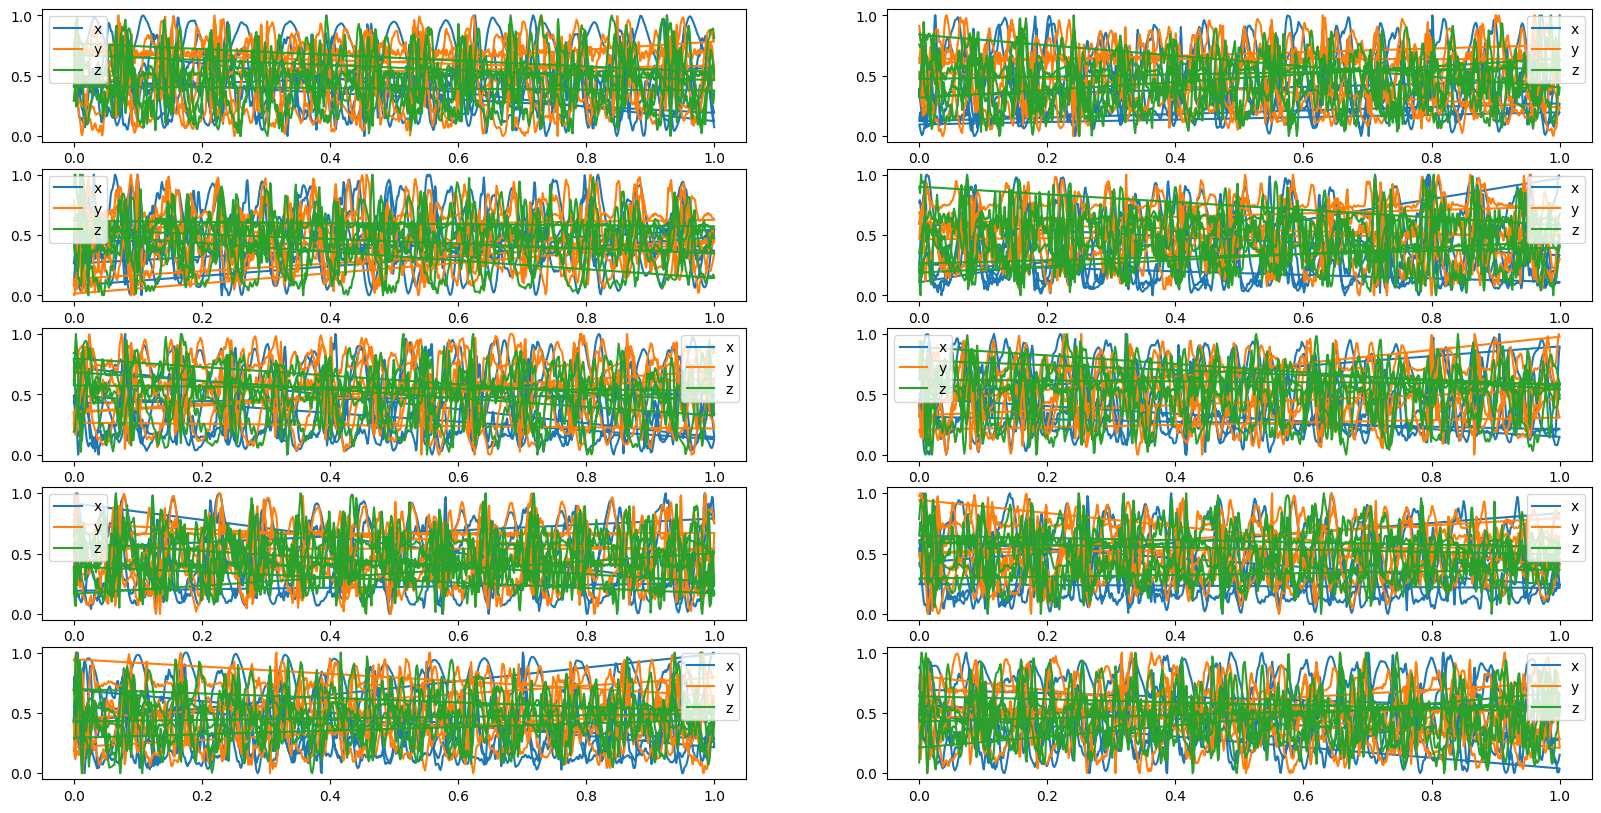

In [7]:
plt.figure(figsize=(20, 10))

for i, dfr in enumerate(df.groupby('i')):
      plt.subplot(5, 2, i + 1)
      for col in dfr[1].columns[1:-2]:
            plt.plot(dfr[1]['time'], dfr[1][col], label=col)
            plt.legend()

In [ ]:
# plt.figure(figsize=(20, 10))

# for i, df in enumerate(aligned_dataframes.values()):
#       plt.subplot(5, 2, i + 1)
#       for col in df.columns[1:]:
#             plt.plot(df['time'], df[col], label=col)
#             plt.legend()

In [ ]:
def segment_data(df, window_size, overlap_size, time_column='time', ):
    """
    Segments the data into fixed-size windows.
    
    Parameters:
    - df: DataFrame containing the accelerometer data.
    - window_size: Size of each window in seconds.
    - overlap_size: Size of the overlap between consecutive windows in seconds.
    - time_column: The name of the column containing the timestamp data.
    
    Returns:
    - A list of segmented DataFrames.
    """
    # Convert timestamps to datetime if not already
    df[time_column] = pd.to_datetime(df[time_column], unit='s')
    
    # Sort the dataframe by timestamp to ensure correct window ordering
    df = df.sort_values(by=time_column)
    
    # Calculate the window step size
    step_size = window_size - overlap_size
    
    # Initialize variables
    segments = []
    start_time = df[time_column].min()
    end_time = start_time + pd.Timedelta(seconds=window_size)

    last_time = df[time_column].max()
    
    # Segment the data
    while start_time + pd.Timedelta(seconds=overlap_size) < last_time:
        # Create a mask for the current window
        mask = (df[time_column] >= start_time) & (df[time_column] < end_time)
        segment = df.loc[mask]
        
        if not segment.empty:
            segments.append(segment)
        
        # Update the start and end times for the next window
        start_time += pd.Timedelta(seconds=step_size)
        end_time = start_time + pd.Timedelta(seconds=window_size)
    
    return segments

segmented_data = segment_data(df, window_size=2, overlap_size=1)
print(segmented_data)

for segment in segmented_data:
    segment['label'] = "circle"
    print(segment)
    # plt.figure(figsize=(20, 5))
    # for col in segment.columns[1:-1]:
    #     plt.plot(segment['time'], segment[col], label=col)
    #     plt.legend()

    # plt.show()

In [ ]:
# Example of extracting simple features: mean and standard deviation
def extract_features(segment):
    features = {}
    for axis in ['x', 'y', 'z', 'abs']:
        features[f'{axis}_mean'] = segment[axis].mean()
        features[f'{axis}_std'] = segment[axis].std()
    return features

# Assuming `segments` is a list of your labeled segments (each a DataFrame)
features_list = [extract_features(segment) for segment in segmented_data]
features_df = pd.DataFrame(features_list)
labels = [segment['label'].iloc[0] for segment in segmented_data]  # Assuming each segment has a uniform label
features_df


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)


In [ ]:
model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


In [ ]:
def predict_gesture(segment):
    features = extract_features(segment)
    features_df = pd.DataFrame([features])  # Convert to DataFrame to match training shape
    prediction = model.predict(features_df)
    return prediction[0]

# Example: Predict the gesture of a new segment
new_segment = segments[0]  # This should be a new, unseen segment
print(predict_gesture(new_segment))


In [ ]:
for i, segment in enumerate(segmented_data):
    plt.figure(figsize=(10, 6))
    for axis in ['acc_x', 'acc_y', 'acc_z']:
        plt.plot(segment['timestamp'], segment[axis], label=axis)
    plt.legend()
    plt.title(f'Segment {i}')
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()
    
    # Prompt for the label
    label = input(f"Enter label for Segment {i}: ")
    segment['label'] = label

In [ ]:
plt.figure(figsize=(20, 5))
for col in df.columns[1:]:
      plt.plot(df['Time (s)'], df[col], label=col)
      plt.legend()
plt.xticks(np.arange(0, df['Time (s)'].max(), 0.5))
plt.show()


In [ ]:
peaks, _ = find_peaks(df['Gyroscope y (rad/s)'], height=1.5)  # Peaks with height > 0
troughs, _ = find_peaks(-df['Gyroscope y (rad/s)'], height=-1.5)  # Troughs in the inverted data

plt.figure(figsize=(20, 5))
# plt.plot(df['Time (s)'], peaks, label='peaks')  # Plot rolling average

for col in df.columns[1:]:
      rolling_avg = df[col].rolling(window=100).mean()  # Calculate rolling average
      plt.plot(df['Time (s)'], rolling_avg, label=col + ' (Rolling Avg)')  # Plot rolling average
      plt.legend()
plt.xticks(np.arange(0, df['Time (s)'].max(), 0.5))
plt.show()
